## import library  

In [237]:
import os
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt

## read data

In [238]:
path_data_istabul = 'data/Istanbul Weather Data normalization.csv'

df = pd.read_csv(path_data_istabul)
print(df.shape)
df.head(10)

(3896, 7)


,DateTime,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
0,2009-01-01,0.005476,0.200,0.225806,0.148148,0.877193,0.760870
1,2009-01-02,0.106667,0.175,0.193548,0.185185,0.859649,0.630435
2,2009-01-03,0.001905,0.200,0.258065,0.259259,0.947368,0.630435
3,2009-01-04,0.069286,0.200,0.258065,0.129630,0.947368,0.478261
4,2009-01-05,0.102857,0.200,0.258065,0.240741,1.000000,0.500000
5,2009-01-06,0.064524,0.200,0.258065,0.370370,0.982456,0.478261
6,2009-01-07,0.005476,0.250,0.225806,0.166667,0.842105,0.652174
7,2009-01-08,0.072857,0.275,0.193548,0.185185,0.842105,0.695652
8,2009-01-09,0.030000,0.150,0.161290,0.388889,0.754386,0.891304
9,2009-01-10,0.000000,0.200,0.161290,0.092593,0.736842,0.782609


In [239]:
def re_organize(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index("DateTime",inplace=True)
    return df
df= re_organize(df)
df

,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
DateTime,,,,,,
2009-01-01,0.005476,0.200,0.225806,0.148148,0.877193,0.760870
2009-01-02,0.106667,0.175,0.193548,0.185185,0.859649,0.630435
2009-01-03,0.001905,0.200,0.258065,0.259259,0.947368,0.630435
2009-01-04,0.069286,0.200,0.258065,0.129630,0.947368,0.478261
2009-01-05,0.102857,0.200,0.258065,0.240741,1.000000,0.500000
...,...,...,...,...,...,...
2019-08-28,0.000000,0.750,0.903226,0.407407,0.368421,0.500000
2019-08-29,0.000000,0.750,0.870968,0.333333,0.421053,0.521739
2019-08-30,0.011905,0.725,0.870968,0.370370,0.403509,0.500000


In [240]:
lookback = 120
cols_target = ['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure']
df_train_transformed = df.reset_index(drop=True)
x = []
t = []
for i in range(1, len(df)-lookback-1):
    x.append(df_train_transformed.loc[i:i+lookback-1,cols_target].values)
    t.append(df_train_transformed.loc[i+lookback,cols_target].values.tolist())
X_train = np.array(x).reshape(-1,lookback,len(cols_target))
y_train = np.array(t)
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)

X_train shape (3774, 120, 6)
y_train shape (3774, 6)


In [241]:
#データの分割
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [242]:
X_train.shape

(3396, 120, 6)

## model(self-attention with 1dCNN) 
https://qiita.com/top4hac/items/2a044b41c69f3c8802ef

In [348]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv1d(in_channels = in_dim, out_channels = in_dim, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels = in_dim, out_channels = in_dim, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels = in_dim, out_channels = in_dim, kernel_size=1)


        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-1)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        proj_query = self.query_conv(X)# サイズ：Batch,Length,Class
        
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        
        proj_key = self.key_conv(X) # サイズ：Batch,Length,Class

        # かけ算
        S = torch.bmm(proj_key,proj_query)  # bmmはバッチごとの行列かけ算です #B,120,120

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X)  # サイズ：Batch,Length,Class
        o = torch.bmm(attention_map,proj_value)  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        out = x+self.gamma*o

        return out, attention_map
    
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
    
class FeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1, padding=2):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(in_dim,300, kernel_size=3,
                                           stride=1, padding=2))
        self.conv2 = weight_norm(nn.Conv1d(300, 200, kernel_size=3,
                                           stride=1, padding=2))
        self.conv3 = weight_norm(nn.Conv1d(200, 100, kernel_size=3,
                                           stride=1, padding=2))
        self.conv4 = weight_norm(nn.Conv1d(100, out_dim, kernel_size=3,
                                           stride=1, padding=2))
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.chomp1 = Chomp1d(padding)
        self.chomp2 = Chomp1d(padding)
        self.chomp3 = Chomp1d(padding)
        self.chomp4 = Chomp1d(padding)
        
    def forward(self, x):
        x = self.dropout1(self.relu(self.chomp1(self.conv1(x))))
        x = self.dropout2(self.relu(self.chomp2(self.conv2(x))))
        x = self.dropout3(self.relu(self.chomp3(self.conv3(x))))
        x = self.dropout4(self.relu(self.chomp4(self.conv4(x))))
        
        return x

In [402]:
class Self_Attention_Model(nn.Module):
    def __init__(self):
        super(Self_Attention_Model, self).__init__()
        
        self.Self_Attention = Self_Attention(in_dim=120)
        self.FeedForward = FeedForward(in_dim=120,out_dim=1, dropout=0.1, padding=2)
    
    def forward(self, x):
        out,attention_map=self.Self_Attention(x)
        out = self.FeedForward(out)
        
        return out,attention_map
    
class FeedForward_attention(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1, padding=2):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(in_dim,300, kernel_size=3,
                                           stride=1, padding=2))
        self.conv2 = weight_norm(nn.Conv1d(300, 200, kernel_size=3,
                                           stride=1, padding=2))
        self.conv3 = weight_norm(nn.Conv1d(200, 100, kernel_size=3,
                                           stride=1, padding=2))
        self.conv4 = weight_norm(nn.Conv1d(100, out_dim, kernel_size=3,
                                           stride=1, padding=2))
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.chomp1 = Chomp1d(padding)
        self.chomp2 = Chomp1d(padding)
        self.chomp3 = Chomp1d(padding)
        self.chomp4 = Chomp1d(padding)
        
        self.Self_Attention1 = Self_Attention(in_dim=120)
        self.Self_Attention2 = Self_Attention(in_dim=300)
        self.Self_Attention3 = Self_Attention(in_dim=200)
        self.Self_Attention4 = Self_Attention(in_dim=100)
        
    def forward(self, x):
        x,at_map = self.Self_Attention1(x)
        x = self.dropout1(self.relu(self.chomp1(self.conv1(x))))
        x,at_map = self.Self_Attention2(x)
        x = self.dropout2(self.relu(self.chomp2(self.conv2(x))))
        x,at_map = self.Self_Attention3(x)
        x = self.dropout3(self.relu(self.chomp3(self.conv3(x))))
        x,at_map = self.Self_Attention4(x)
        x = self.dropout4(self.relu(self.chomp4(self.conv4(x))))
        
        return x,at_map

In [403]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [404]:
from sklearn.utils import shuffle
import numpy as np
import torch
import torch.optim as optimizers

np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 200
batch_size = 256
n_batches_train = X_train.shape[0] // batch_size + 1
n_batches_val = X_val.shape[0] // batch_size + 1
learning_rate = 0.01

input_size = 6
hidden_size = 100
num_layers = 1

num_classes = 6

hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

model = FeedForward_attention(in_dim=120, out_dim=1).to(device)

# mse=nn.L1Loss()
optimizer = optimizers.Adam(model.parameters(),lr=0.001)
# optimizer = optimizers.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
#                             lr=0.001),
#                             betas=(0.9, 0.999), amsgrad=True)


criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
model

FeedForward_attention(
  (conv1): Conv1d(120, 300, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv2): Conv1d(300, 200, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv3): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv4): Conv1d(100, 1, kernel_size=(3,), stride=(1,), padding=(2,))
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (chomp1): Chomp1d()
  (chomp2): Chomp1d()
  (chomp3): Chomp1d()
  (chomp4): Chomp1d()
  (Self_Attention1): Self_Attention(
    (query_conv): Conv1d(120, 120, kernel_size=(1,), stride=(1,))
    (key_conv): Conv1d(120, 120, kernel_size=(1,), stride=(1,))
    (value_conv): Conv1d(120, 120, kernel_size=(1,), stride=(1,))
    (softmax): Softmax(dim=-1)
  )
  (Self_Attention2): Self_Attention(
    (query_conv): Conv1d(300, 300, kernel_size=(1,), stride=(1,))
    (key_conv): Conv1d(300, 300, ke

In [405]:
preds_0 = 0
t_0 = 0

def train_step(x, t):

    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds ,attention= model(x)
#     print(preds.shape,t.shape)
    loss = criterion(preds.view(-1),t.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds ,attention= model(x)
    loss = criterion(preds.view(-1), t.view(-1))

    return loss, preds

## train the TCN

In [406]:
for epoch in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    x_, y_ = shuffle(X_train, y_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
#         print(start, end)
#         print(x_.shape,y_.shape)
        loss, _ = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(X_val[start:end], y_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 0.0852, val_loss: 0.0229
epoch: 2, loss: 0.0433, val_loss: 0.0172
epoch: 3, loss: 0.0373, val_loss: 0.0155
epoch: 4, loss: 0.0359, val_loss: 0.0133
epoch: 5, loss: 0.0345, val_loss: 0.0141
epoch: 6, loss: 0.0371, val_loss: 0.0166
epoch: 7, loss: 0.0354, val_loss: 0.016
epoch: 8, loss: 0.0352, val_loss: 0.0146
epoch: 9, loss: 0.0346, val_loss: 0.0127
epoch: 10, loss: 0.0335, val_loss: 0.0119
epoch: 11, loss: 0.0343, val_loss: 0.0113
epoch: 12, loss: 0.0345, val_loss: 0.0117
epoch: 13, loss: 0.036, val_loss: 0.012
epoch: 14, loss: 0.0337, val_loss: 0.0113
epoch: 15, loss: 0.0338, val_loss: 0.0121
epoch: 16, loss: 0.031, val_loss: 0.0123
epoch: 17, loss: 0.032, val_loss: 0.013
epoch: 18, loss: 0.0323, val_loss: 0.0125
epoch: 19, loss: 0.0321, val_loss: 0.0118
epoch: 20, loss: 0.031, val_loss: 0.0128
epoch: 21, loss: 0.0315, val_loss: 0.0104
epoch: 22, loss: 0.0305, val_loss: 0.00928
epoch: 23, loss: 0.0324, val_loss: 0.0128
epoch: 24, loss: 0.0323, val_loss: 0.0105
epoch: 

## predict rainfall, temp,wind,humidity and pressure

In [393]:
model.eval()
x_ = torch.Tensor(X_val).to(device)
preds_val ,at_map= model(x_)
preds_val=preds_val.data.cpu().numpy()
preds_val=preds_val.reshape(-1,6)
preds_val.shape

(378, 6)

In [394]:
df_preds_val = pd.DataFrame(preds_val,columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])
df_val = pd.DataFrame(y_val, columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])

In [395]:
df_preds_val

,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
0,0.000000,0.686687,0.837652,0.406306,0.323092,0.409591
1,0.000000,0.676160,0.824352,0.382250,0.374351,0.401224
2,0.001597,0.674539,0.809778,0.305339,0.413487,0.403994
3,0.000000,0.684256,0.825303,0.352562,0.375089,0.410011
4,0.000000,0.682740,0.839091,0.414903,0.315716,0.396819
...,...,...,...,...,...,...
373,0.000000,0.690949,0.816438,0.391513,0.350228,0.431693
374,0.000402,0.664558,0.803984,0.407936,0.329832,0.432000
375,0.013919,0.624794,0.769831,0.369564,0.389678,0.442705
376,0.016494,0.635820,0.760072,0.309499,0.394287,0.457330


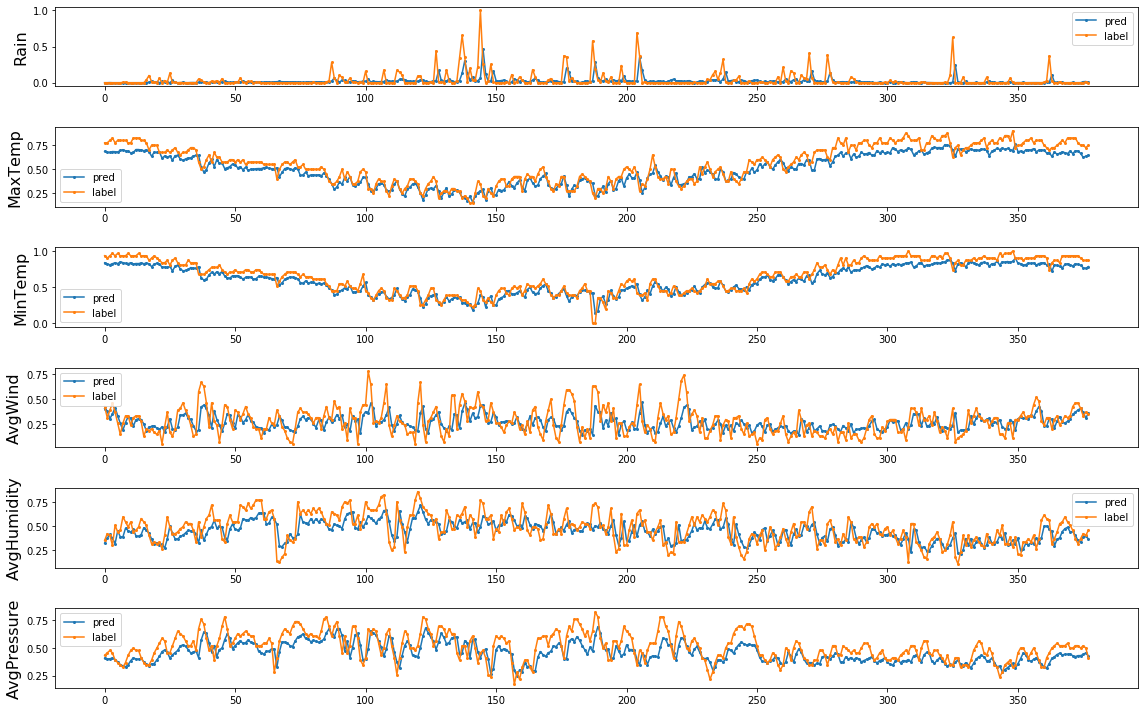

In [396]:
import matplotlib.pyplot as plt

col_vals = ['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure']
nrows = len(col_vals)
width = 16
height = 10

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_val.index, df_preds_val[col], marker='o', markersize=2, label='pred')
    axs[i].plot(df_val.index, df_val[col], marker='o', markersize=2, label='label')
    axs[i].set_ylabel(col, fontsize=16)
    axs[i].legend()

plt.tight_layout()
plt.show()

## check laerning progress

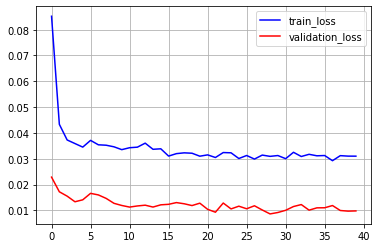

In [358]:
plt.plot(range(len(hist["loss"])),hist["loss"],
         color='blue', linestyle='-', label='train_loss')
plt.plot(range(len(hist["val_loss"])), hist["val_loss"],
         color='r', linestyle='-', label='validation_loss')

plt.legend()
plt.grid()

In [294]:
from sklearn.utils import shuffle
import numpy as np
import torch
import torch.optim as optimizers

np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 200
batch_size = 256
n_batches_train = X_train.shape[0] // batch_size + 1
n_batches_val = X_val.shape[0] // batch_size + 1
learning_rate = 0.01

input_size = 6
hidden_size = 100
num_layers = 1

num_classes = 6

hist = {'loss': [], 'val_loss': []}
es = EarlyStopping(patience=10, verbose=1)

model = FeedForward(in_dim=120,out_dim=1).to(device)

# mse=nn.L1Loss()
optimizer = optimizers.Adam(model.parameters(),lr=0.001)
# optimizer = optimizers.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
#                             lr=0.001),
#                             betas=(0.9, 0.999), amsgrad=True)


criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
model

FeedForward(
  (conv1): Conv1d(120, 300, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv2): Conv1d(300, 200, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv3): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(2,))
  (conv4): Conv1d(100, 1, kernel_size=(3,), stride=(1,), padding=(2,))
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (dropout4): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (chomp1): Chomp1d()
  (chomp2): Chomp1d()
  (chomp3): Chomp1d()
  (chomp4): Chomp1d()
)

In [295]:
preds_0 = 0
t_0 = 0

def train_step(x, t):

    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.train()
    preds = model(x)
#     print(preds.shape,t.shape)
    loss = criterion(preds.view(-1),t.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    x = torch.Tensor(x).to(device)
    t = torch.Tensor(t).to(device)
    model.eval()
    preds= model(x)
    loss = criterion(preds.view(-1), t.view(-1))

    return loss, preds

In [296]:
for epoch in range(num_epochs):
    train_loss = 0.
    val_loss = 0.
    x_, y_ = shuffle(X_train, y_train)

    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
#         print(start, end)
#         print(x_.shape,y_.shape)
        loss, _ = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        loss, _ = val_step(X_val[start:end], y_val[start:end])
        val_loss += loss.item()

    train_loss /= n_batches_train
    val_loss /= n_batches_val

    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)

    print('epoch: {}, loss: {:.3}, val_loss: {:.3}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))

    if es(val_loss):
        break

epoch: 1, loss: 0.0856, val_loss: 0.0232
epoch: 2, loss: 0.0449, val_loss: 0.0181
epoch: 3, loss: 0.0392, val_loss: 0.0167
epoch: 4, loss: 0.0373, val_loss: 0.0137
epoch: 5, loss: 0.0369, val_loss: 0.0151
epoch: 6, loss: 0.0359, val_loss: 0.0168
epoch: 7, loss: 0.0348, val_loss: 0.0163
epoch: 8, loss: 0.036, val_loss: 0.0155
epoch: 9, loss: 0.0353, val_loss: 0.0134
epoch: 10, loss: 0.035, val_loss: 0.0121
epoch: 11, loss: 0.0344, val_loss: 0.0155
epoch: 12, loss: 0.0367, val_loss: 0.0132
epoch: 13, loss: 0.0342, val_loss: 0.0122
epoch: 14, loss: 0.035, val_loss: 0.0103
epoch: 15, loss: 0.033, val_loss: 0.0102
epoch: 16, loss: 0.0338, val_loss: 0.015
epoch: 17, loss: 0.033, val_loss: 0.0129
epoch: 18, loss: 0.0325, val_loss: 0.0102
epoch: 19, loss: 0.0329, val_loss: 0.011
epoch: 20, loss: 0.0329, val_loss: 0.0103
epoch: 21, loss: 0.0331, val_loss: 0.011
epoch: 22, loss: 0.0327, val_loss: 0.0102
epoch: 23, loss: 0.0324, val_loss: 0.012
epoch: 24, loss: 0.0333, val_loss: 0.0101
epoch: 25,

In [297]:
model.eval()
x_ = torch.Tensor(X_val).to(device)
preds_val = model(x_).data.cpu().numpy()
preds_val=preds_val.reshape(-1,6)
preds_val.shape

(378, 6)

In [298]:
df_preds_val = pd.DataFrame(preds_val,columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])
df_val = pd.DataFrame(y_val, columns=['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure'])

In [299]:
df_preds_val

,Rain,MaxTemp,MinTemp,AvgWind,AvgHumidity,AvgPressure
0,0.016793,0.713404,0.848773,0.374583,0.329771,0.423113
1,0.014310,0.694384,0.833164,0.348762,0.365744,0.401589
2,0.016510,0.679857,0.808123,0.293592,0.384423,0.403169
3,0.016997,0.690741,0.822579,0.340630,0.358573,0.415186
4,0.016510,0.705882,0.840569,0.377755,0.304304,0.405516
...,...,...,...,...,...,...
373,0.015798,0.698255,0.818249,0.362370,0.349523,0.429374
374,0.014801,0.690934,0.807813,0.369911,0.322872,0.428426
375,0.028165,0.623201,0.753286,0.342963,0.362626,0.439956
376,0.026493,0.625521,0.747759,0.299079,0.372586,0.452072


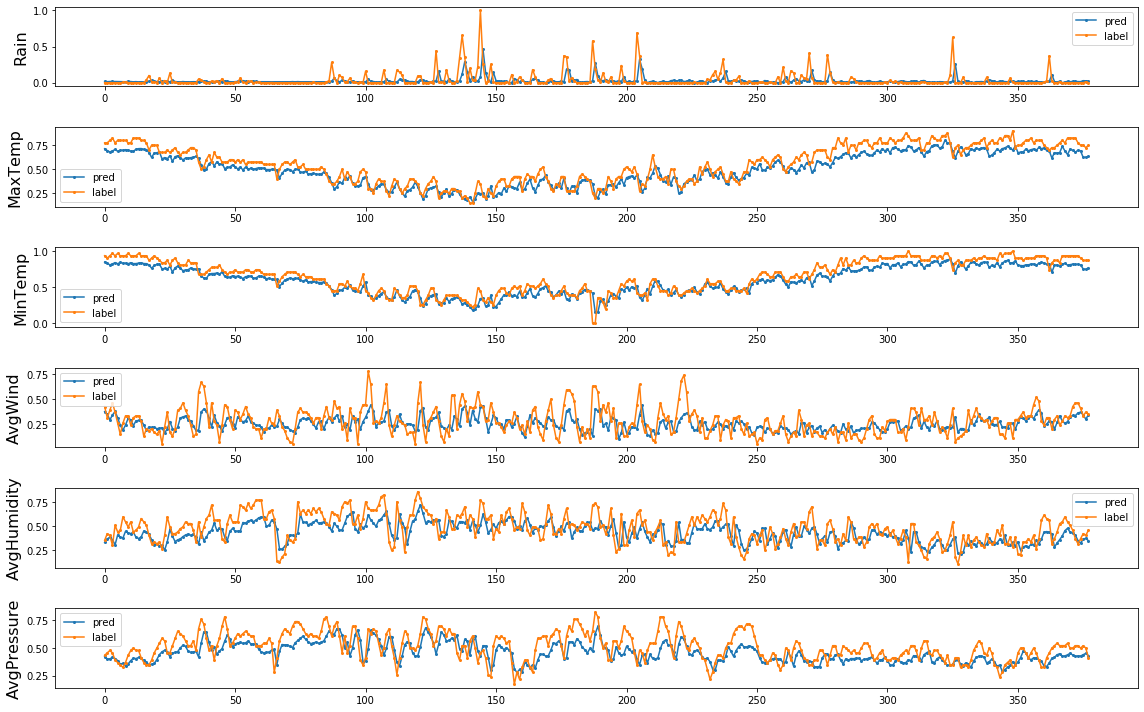

In [300]:
import matplotlib.pyplot as plt

col_vals = ['Rain', 'MaxTemp', 'MinTemp', 'AvgWind', 'AvgHumidity', 'AvgPressure']
nrows = len(col_vals)
width = 16
height = 10

fig, axs = plt.subplots(nrows, 1, figsize=(width, height), facecolor='w')
axs = axs.ravel()
for i, col in enumerate(col_vals):
    axs[i].plot(df_preds_val.index, df_preds_val[col], marker='o', markersize=2, label='pred')
    axs[i].plot(df_val.index, df_val[col], marker='o', markersize=2, label='label')
    axs[i].set_ylabel(col, fontsize=16)
    axs[i].legend()

plt.tight_layout()
plt.show()

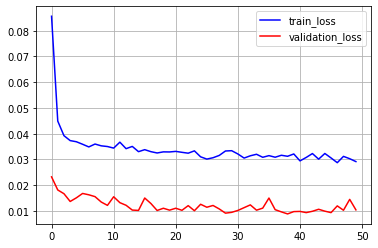

In [192]:
plt.plot(range(len(hist["loss"])),hist["loss"],
         color='blue', linestyle='-', label='train_loss')
plt.plot(range(len(hist["val_loss"])), hist["val_loss"],
         color='r', linestyle='-', label='validation_loss')

plt.legend()
plt.grid()

In [382]:
class Attention(nn.Module):
    '''Transformerは本当はマルチヘッドAttentionですが、
    分かりやすさを優先しシングルAttentionで実装します'''

    def __init__(self, d_model=300):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
#         mask = mask.unsqueeze(1)
#         weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [383]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x



In [390]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
#         self.norm_1 = nn.LayerNorm(d_model)
#         self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        # 正規化とAttention
#         x_normlized = self.norm_1(x)
        x_normlized = x
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized)
        
        x2 = x + self.dropout_1(output)

#         正規化と全結合層
#         x_normlized2 = self.norm_2(x2)
        x_normlized2 = x2
        output = x2 + self.dropout_2(self.ff(x_normlized2))

        return output, normlized_weights



In [392]:
net3 = TransformerBlock(d_model=120)
x=torch.tensor(X_train)
net3(x)

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm